In [ ]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [4]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
55,76666.68,0,16,24846.60026
41,57463.74,0,15,23114.95042
42,41296.05,0,10,19485.88872
43,96446.05,0,17,38476.10072
45,64387.60,0,10,23609.01780


In [5]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [6]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [72.89, 78.67]


In [7]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [8]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [9]:
# GroupKFold em um pipeline com StandardScaler e SVC
from sklearn.model_selection import GroupKFold

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.07, 79.29]


In [10]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.80
Intervalo [72.90, 78.69]


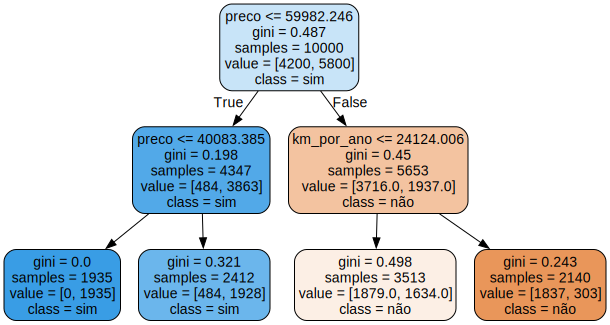

In [11]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)

graph = graphviz.Source(dot_data)
graph

In [12]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo_com_3 = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo_com_3, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.68
Intervalo [75.57, 81.80]


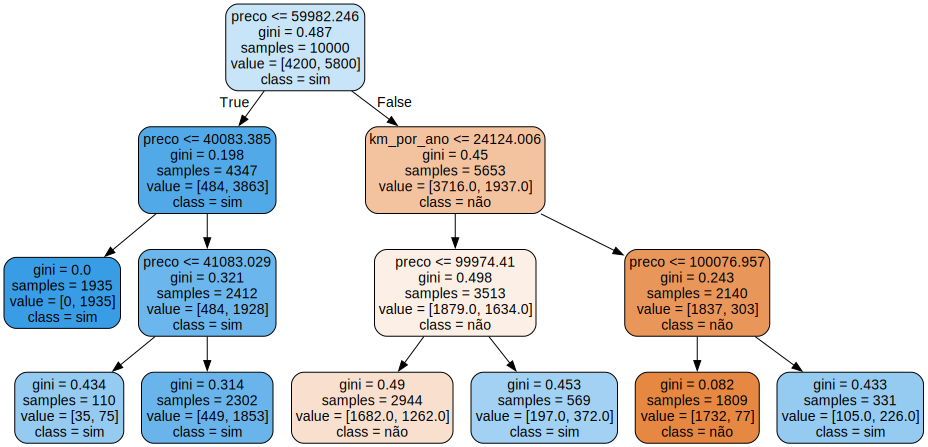

In [13]:
from sklearn.tree import export_graphviz
import graphviz

modelo_com_3.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo_com_3, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)

graph = graphviz.Source(dot_data)
graph

In [14]:
from sklearn.model_selection import GroupKFold


def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    #print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, train_score, test_score))
    tabela = [ max_depth, train_score, test_score]
    return tabela


resultados_lista = [roda_arvore_de_decisao(i) for i in range(1, 33)]

In [15]:
resultados = pd.DataFrame(resultados_lista, columns=["max_depth", "train", "test"])
resultados.head()

,max_depth,train,test
0,1,75.791308,75.795015
1,2,75.791308,75.795015
2,3,78.751166,78.683167
3,4,78.788947,78.663124
4,5,78.949014,78.591557


<Axes: xlabel='max_depth', ylabel='train'>

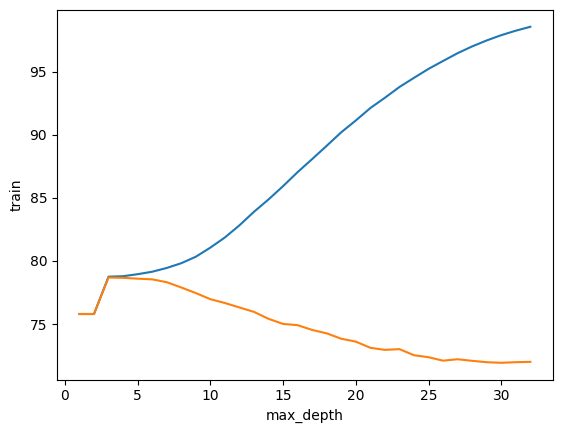

In [20]:
import seaborn as sns

sns.lineplot(x="max_depth", y="train", data=resultados)
sns.lineplot(x="max_depth", y="test", data=resultados)

In [27]:
from sklearn.model_selection import GroupKFold


def roda_arvore_de_decisao_2(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    #print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, train_score, test_score))
    tabela = [ max_depth, min_samples_leaf, train_score, test_score]
    return tabela

def busca(): 
    resultados_lista_2 = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao_2(max_depth, min_samples_leaf)
            resultados_lista_2.append(tabela)

    return pd.DataFrame(resultados_lista_2, columns=["max_depth", "min_samples_leaf", "train", "test"])

In [28]:
resultados_2 = busca()

In [29]:
resultados_2.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.751166,78.683167
14,4,128,78.751166,78.683167
13,4,64,78.751166,78.683167
12,4,32,78.751166,78.683167
11,3,256,78.751166,78.683167


<Axes: xlabel='max_depth', ylabel='train'>

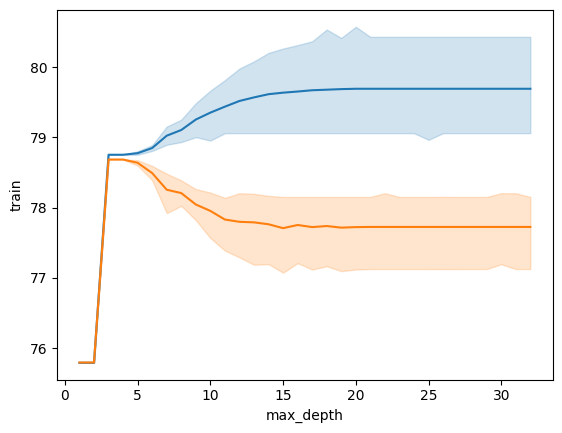

In [30]:
import seaborn as sns

sns.lineplot(x="max_depth", y="train", data=resultados_2)
sns.lineplot(x="max_depth", y="test", data=resultados_2)

In [32]:
corr = resultados_2.corr()

<Axes: >

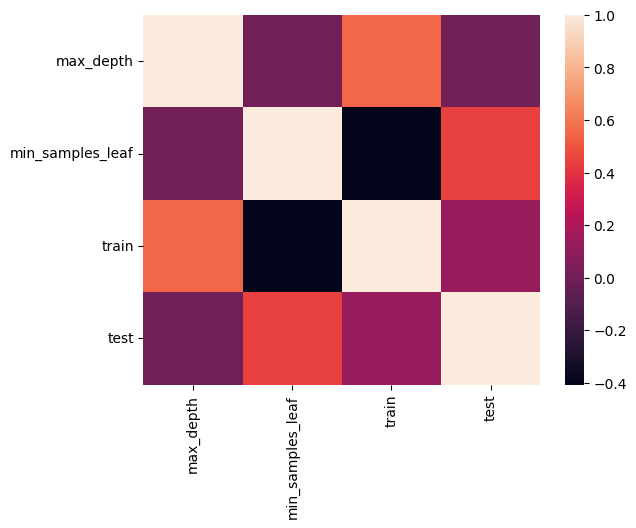

In [33]:
sns.heatmap(corr)

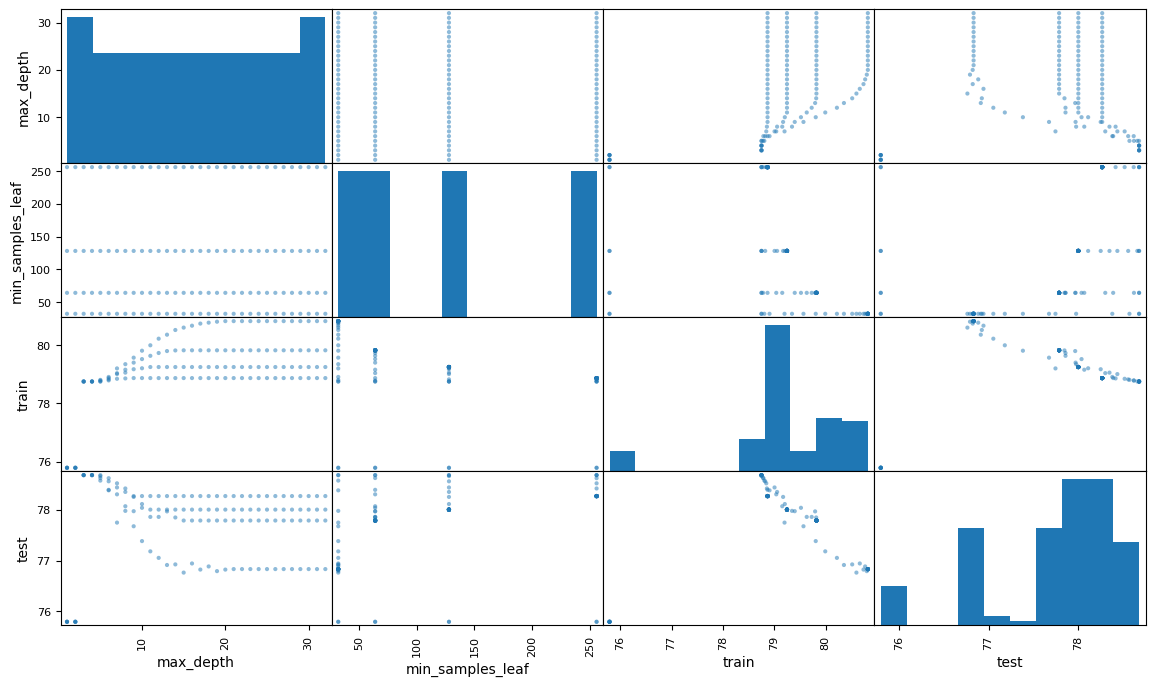

In [38]:
from pandas.plotting import scatter_matrix

scatter_matrix(resultados_2, figsize=(14,8));